# Siamese Network with Triplet Loss

## Importing Libraries

In [1]:
import random
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

**Siamese Network**
+ We will use three images for each training example:
    - Anchor Example
    - Positive Example
    - Negative Example
+ All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.
+ The three instances of the EmbeddingModel are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.
![Siamese Network](siamese.png)

## Importing the Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print('X-train:', x_train.shape)
print('Y-train:', y_train.shape)
print('X-test: ', x_test.shape)
print('Y-test: ', y_test.shape)

X-train: (60000, 28, 28)
Y-train: (60000,)
X-test:  (10000, 28, 28)
Y-test:  (10000,)


## Normalizing the Images

In [4]:
x_train = x_train/255.
x_test = x_test/255.

## Customizing Dimensions

+ Conv2D expects tensor format i.e., (batch_size, height, width, depth)

In [5]:
x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)

## Visualizing the Triplets

In [6]:
def plot_triplet(triplet, titles=['Anchor', 'Positive', 'Negative'], size=(10, 5)):
    plt.figure(figsize=size)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        plt.title(titles[i])
        
        img = triplet[i]
        if(len(img.shape)==4):
            img = img[0]
        plt.imshow(np.squeeze(img, axis=2), cmap='binary')

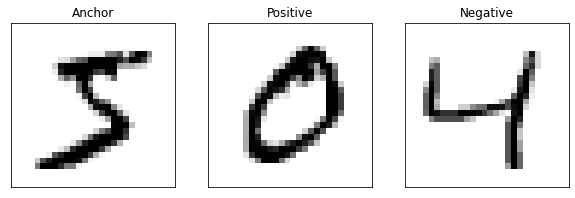

In [7]:
# demo
plot_triplet((x_train[0], x_train[1], x_train[2]))

## A Batch of Triplets

In [8]:
def create_batch(batch_size, x, y):
    anchors = np.zeros((batch_size, x.shape[1], x.shape[2], x.shape[3]))
    positives = np.zeros((batch_size, x.shape[1], x.shape[2], x.shape[3]))
    negatives = np.zeros((batch_size, x.shape[1], x.shape[2], x.shape[3]))
        
    for i in range(batch_size):
        index = random.randint(0, x.shape[0]-1)
        anchor = x[index]
        
        indices_for_pos = np.squeeze(np.where(y == y[index]))
        indices_for_neg = np.squeeze(np.where(y != y[index]))
        
        pos = x[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]
        
        anchors[i] = anchor
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

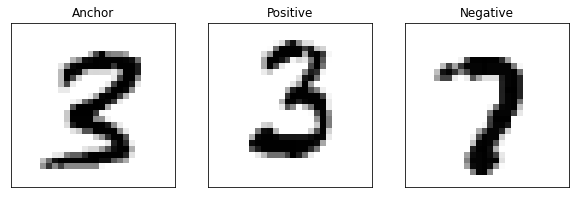

In [9]:
plot_triplet(create_batch(1, x_train, y_train))

## Embedding Model

In [10]:
emb_dim = 32
input_shape = (28, 28, 1)

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(emb_dim, activation='softmax')
])

In [11]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                173120    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
Total params: 175,360
Trainable params: 175,360
Non-trainable params: 0
_________________________________________________________________


## Siamese Model

In [12]:
in_anch = tf.keras.layers.Input(shape=input_shape)
in_pos = tf.keras.layers.Input(shape=input_shape)
in_neg = tf.keras.layers.Input(shape=input_shape)

emb_anch = embedding_model(in_anch)
emb_pos = embedding_model(in_pos)
emb_neg = embedding_model(in_neg)

stacked_output = tf.keras.layers.concatenate([emb_anch, emb_pos, emb_neg], axis=-1)

In [13]:
model = tf.keras.models.Model([in_anch, in_pos, in_neg], stacked_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           175360      input_1[0][0]                    
                                                                 input_2[0][0]                

## Triplet Loss

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [14]:
def triplet_loss(emb_dim, alpha=0.2):
    def loss(y_true, y_pred):
        anch, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:3*emb_dim]
        dp = tf.reduce_mean(tf.square(anch - pos), axis=-1)
        dn = tf.reduce_mean(tf.square(anch - neg), axis=-1)
        return tf.maximum(dp-dn+alpha, 0)
    return loss

## Compiling the Model

+ Here metrics for 'acc' doesn't matter

In [15]:
model.compile(loss=triplet_loss(emb_dim, alpha=0.2), optimizer='adam')

## Data Generator

In [16]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size, x_train, y_train)
        y = np.zeros((batch_size, 3*emb_dim))            # doesn't really take into account
        yield x, y

## Model Training

In [17]:
epochs = 10
batch_size = 1024
steps_per_epoch = int(x_train.shape[0]/batch_size)
val_batch_size = 64
validation_steps = int(x_test.shape[0]/val_batch_size)

In [18]:
history = model.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=data_generator(val_batch_size, emb_dim),
    validation_steps=validation_steps    
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 156 steps
Epoch 1/10
58/58 [==============================] - 59s 1s/step - loss: 0.1866 - val_loss: 0.1682
Epoch 2/10
58/58 [==============================] - 54s 931ms/step - loss: 0.1669 - val_loss: 0.1661
Epoch 3/10
58/58 [==============================] - 65s 1s/step - loss: 0.1656 - val_loss: 0.1652
Epoch 4/10
58/58 [==============================] - 67s 1s/step - loss: 0.1651 - val_loss: 0.1651
Epoch 5/10
58/58 [==============================] - 65s 1s/step - loss: 0.1650 - val_loss: 0.1646
Epoch 6/10
58/58 [==============================] - 59s 1s/step - loss: 0.1645 - val_loss: 0.1644
Epoch 7/10
58/58 [==============================] - 58s 996ms/step - loss: 0.1643 - val_loss: 0.1639
Epoch 8/10
58/58 [==============================] - 56s 961ms/step - loss: 0.1641 - val_loss: 0.1636
Epoch 9/10
58/58 [==============================] - 70s 1s/step - loss: 0.1641 - val_loss: 0.1638
Epoch 10/10
58/5

## Analyzing the training

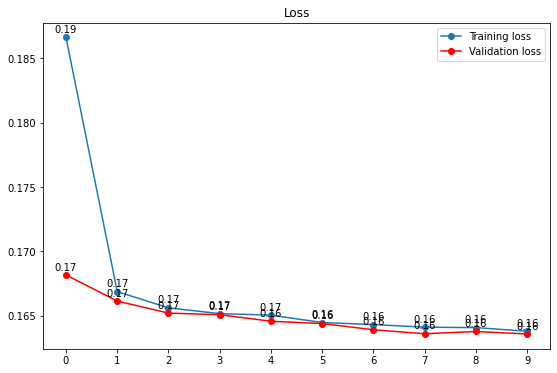

In [19]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Training loss')
plt.title('Loss')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_loss'], color='r', marker='o', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

+ We have completed successfully Siamese Network.
+ The output is the embedding vector which can be used for classification (verification).

## Saving the Model

In [20]:
model.save('siamese_model.h5')

embedding_model.save('embedding_model.h5')

## Loading the Model

In [21]:
# We have to load the custom_objects of loss
# model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'loss': triplet_loss(emb_dim)})

# However, if we wish to just perform inference with our model & not further optimize or train our model,
# we can simply wish to ignore the loss function
# model = tf.keras.models.load_model('siamese_model.h5', compile=False)

# only loading embedding model as we will be only interested in embeddings now
model = tf.keras.models.load_model('embedding_model.h5', compile=False)

## Testing the Model

### Type-1

+ **Input**: Two images
+ **Output**: Are they of same identity based on embeddings

In [22]:
# returns one list having two seperate list of images and second list of 0's & 1's as one-to-one mapping
def create_data(size, x, y):
    if(size%2!=0):
        size += 1
        
    new_x1 = np.zeros((size, x.shape[1], x.shape[2], x.shape[3]))
    new_x2 = np.zeros((size, x.shape[1], x.shape[2], x.shape[3]))
    new_y = np.zeros((size, 1))
    
    for i in range(0, size, 2):
        index1 = random.randint(0, x.shape[0]-1)
        
        indices2 = np.squeeze(np.where(y == y[index1]))
        index2 = indices2[random.randint(0, len(indices2)-1)]
        
        indices3 = np.squeeze(np.where(y != y[index1]))
        index3 = indices3[random.randint(0, len(indices3)-1)]
        
        new_x1[i], new_x2[i], new_y[i] = x[index1], x[index2], 1
        new_x1[i+1], new_x2[i+1] = x[index1], x[index3]
        
    new_x1, new_x2, new_y = shuffle(new_x1, new_x2, new_y)
    return np.array([new_x1, new_x2]), new_y

In [23]:
img_train, label_train = create_data(size=64, x=x_train, y=y_train)

print(img_train.shape)
print(label_train.shape)

(2, 64, 28, 28, 1)
(64, 1)


1.0


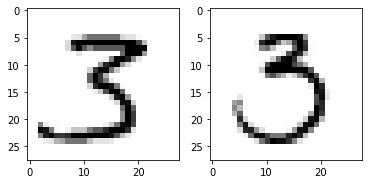

In [24]:
n = 1
print(label_train[n][0])
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img_train[0][n], axis=2), cmap='binary')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(img_train[1][n], axis=2), cmap='binary')

In [25]:
embeddings1 = model.predict(img_train[0])
embeddings2 = model.predict(img_train[1])

In [26]:
print(embeddings1.shape)
print(embeddings2.shape)

(64, 32)
(64, 32)


In [27]:
# Cosine_Similarity => cos0 where 0 is the angle between two pts. => [-1, 1]
# Cosine_Distance => 1-cosine_similarity => [0, 2] => lower means higher similarity
def measure_distance(x, y, threshold=0.4, metrics=0):
    '''
        metrics: 0 (cosine-distance) or 1 (euclidean-distance)
    '''
    result = []
    for i in range(x.shape[0]):
        a, b = np.expand_dims(x[i], axis=0), np.expand_dims(y[i], axis=0)
        if(metrics):
            result.append(int(euclidean_distances(a, b)[0][0] < threshold))
        else:
            result.append(int(cosine_distances(a, b)[0][0] < threshold))
    return result

In [28]:
label_pred = measure_distance(x=embeddings1, y=embeddings2, threshold=0.4, metrics=0)

# By definition a confusion matrix 'C' is such that 'C(i,j)' is
# equal to the number of observations known to be in group 'i' & predicted to be in group 'j'.
# Thus in binary classification, the count of true negatives is 'C(0,0)', false negatives is 'C(1,0)',
# true positives is 'C(1,1)' and false positives is 'C(0,1)'.

print('Confusion Matrix:\n', confusion_matrix(label_train, label_pred), end='\n\n')
print('Accuracy Score:\n', accuracy_score(label_train, label_pred), end='\n\n')
print('Classification Report:\n', classification_report(label_train, label_pred))

Confusion Matrix:
 [[19 13]
 [ 0 32]]

Accuracy Score:
 0.796875

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.59      0.75        32
         1.0       0.71      1.00      0.83        32

    accuracy                           0.80        64
   macro avg       0.86      0.80      0.79        64
weighted avg       0.86      0.80      0.79        64



### Type-2

+ **Input**: A single image
+ **Output**: Predicting class

In [29]:
embeddings = model.predict(x_train)

In [30]:
embeddings.shape

(60000, 32)

In [31]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(units=emb_dim, activation='relu', input_dim=emb_dim),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

classifier.fit(
    x=model.predict(x_train),
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(model.predict(x_test), y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/sample - loss: 1.5339 - acc: 0.3051 - val_loss: 1.4586 - val_acc: 0.3132
Epoch 2/10
60000/60000 [==============================] - 3s 58us/sample - loss: 1.4481 - acc: 0.3124 - val_loss: 1.4580 - val_acc: 0.3048
Epoch 3/10
60000/60000 [==============================] - 4s 60us/sample - loss: 1.4482 - acc: 0.3086 - val_loss: 1.4576 - val_acc: 0.3092
Epoch 4/10
60000/60000 [==============================] - 4s 59us/sample - loss: 1.4479 - acc: 0.3103 - val_loss: 1.4577 - val_acc: 0.3076
Epoch 5/10
60000/60000 [==============================] - 4s 59us/sample - loss: 1.4477 - acc: 0.3077 - val_loss: 1.4570 - val_acc: 0.3122
Epoch 6/10
60000/60000 [==============================] - 3s 58us/sample - loss: 1.4474 - acc: 0.3105 - val_loss: 1.4579 - val_acc: 0.3121
Epoch 7/10
60000/60000 [==============================] - 3s 58us/sample - loss: 1.4473 - acc: 0.3121 - val_loss: 1.

In [32]:
# predict
yhat_train = np.argmax(classifier.predict(model.predict(x_train)), axis=1)
yhat_test = np.argmax(classifier.predict(model.predict(x_test)), axis=1)

# score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=31.568, test=31.090


In [33]:
# # dimensional reduction
# pca = PCA(n_components=2)
# pca_x_train = pca.fit_transform(embeddings)
# pca_x_test = pca.transform(model.predict(x_test))

# # building the classifier
# classifier = SVC(kernel='linear', probability=True)
# classifier.fit(pca_x_train, y_train)

# # predict
# yhat_train = classifier.predict(pca_x_train)
# yhat_test = classifier.predict(pca_x_test)

# # score
# score_train = accuracy_score(y_train, yhat_train)
# score_test = accuracy_score(y_test, yhat_test)

# # summarize
# print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))